In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


In [3]:
testX = np.load("drive/MyDrive/Datasets/lc2/v2/testX.npy").astype(np.float32)
testY = np.load("drive/MyDrive/Datasets/lc2/v2/testY.npy").astype(np.float32)

In [4]:
testX = (testX-127.0)/127.0
testY = (testY>127).astype(np.float32)

In [5]:
print(testX.dtype)
print(testY.dtype)

float32
float32


In [6]:
testX = np.reshape(testX, (len(testX), 512, 512, 1))
testY = np.reshape(testY, (len(testY), 512, 512, 1))

print(testX.shape)
print(testY.shape)

(457, 512, 512, 1)
(457, 512, 512, 1)


In [7]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [8]:
model_c = tf.keras.models.load_model("drive/MyDrive/Datasets/lc2/v2/Training_Logs/1st_Trial/LC2_UNet_best_Model_checkpoint.h5", custom_objects={'dice_coef':dice_coef, 'dice_coef_loss':dice_coef_loss})
model = tf.keras.models.load_model("drive/MyDrive/Datasets/lc2/v2/Training_Logs/1st_Trial/LC2_v2_UNet.h5", custom_objects={'dice_coef':dice_coef, 'dice_coef_loss':dice_coef_loss})

In [10]:
# model.summary()

In [11]:
with tf.device("/device:GPU:0"):
  pred = model.predict(testX)
  pred_c = model_c.predict(testX)

In [12]:
def display(true, pred, X, m=0, n=50):
  n = len(list(true[m:n]))
  r = n//2 if n%2==0 else (n//2)+1
  plt.figure(figsize=(20,5*r))
  for i,(t, p, x) in enumerate(zip(true[m:n],pred[m:n],X[m:n])):
    t = np.squeeze(t)
    p = np.squeeze(p)
    x = np.squeeze(x)
    groundtruth = cv2.addWeighted(x,.5,t,.5,0)
    prediction = cv2.addWeighted(x,.5,p,.5,0)
    plt.subplot(r,2,i+1)
    plt.title("GroundTruth"+" "*36+"Prediction")
    ig = np.hstack((groundtruth, prediction))
    plt.imshow(ig, cmap="bone")

In [13]:
display(testY,pred,testX)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
display(testY,pred_c,testX)

Output hidden; open in https://colab.research.google.com to view.

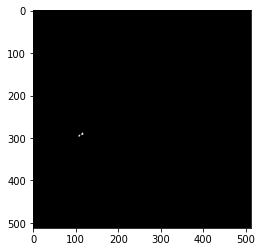

In [33]:
import copy
m = copy.deepcopy(np.squeeze(pred_c[46]))
plt.imshow(m, cmap="gray")

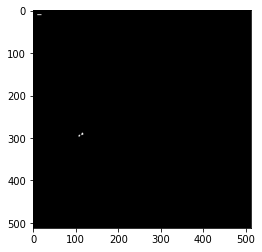

In [34]:
import cv2
m2 = m.copy()
m2[10:12,10:20] = 1
plt.imshow(m2, cmap="gray")

In [39]:
from skimage import measure
m[m>=0.5] = 255
m[m<0.5] = 0
m = m.astype(np.uint8)
labels = measure.label(m)
regions = measure.regionprops(labels)

In [44]:
np.unique(labels)

array([0, 1, 2])

In [45]:
regions

In [47]:
bb, cc, dd = [], [], []
for prop in regions:
  B = prop.bbox
  C = prop.centroid
  D = prop.equivalent_diameter
  bb.append((( max(0, B[1]-8), max(0, B[0]-8) ),( min(B[3]+8, 512), min(B[2]+8, 512) )))    # ((x1,y1),(x2,y2))
  cc.append(C)    # (y,x)
  dd.append(D)

In [48]:
bb, cc, dd

([((105, 280), (126, 302)), ((99, 285), (119, 306))],
 [(290.45, 115.3), (294.6666666666667, 108.46666666666667)],
 [5.046265044040321, 4.370193722368317])

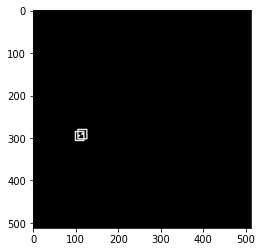

In [54]:
m2 = m.copy()
for rect in bb:
  m2 = cv2.rectangle(m2, rect[0], rect[1], (255), 2)
plt.imshow(m2, cmap="gray")

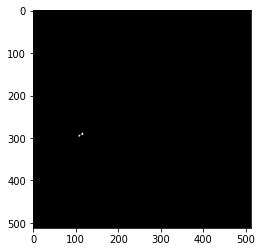

In [51]:
plt.imshow(m, cmap="gray")

8.06225774829855


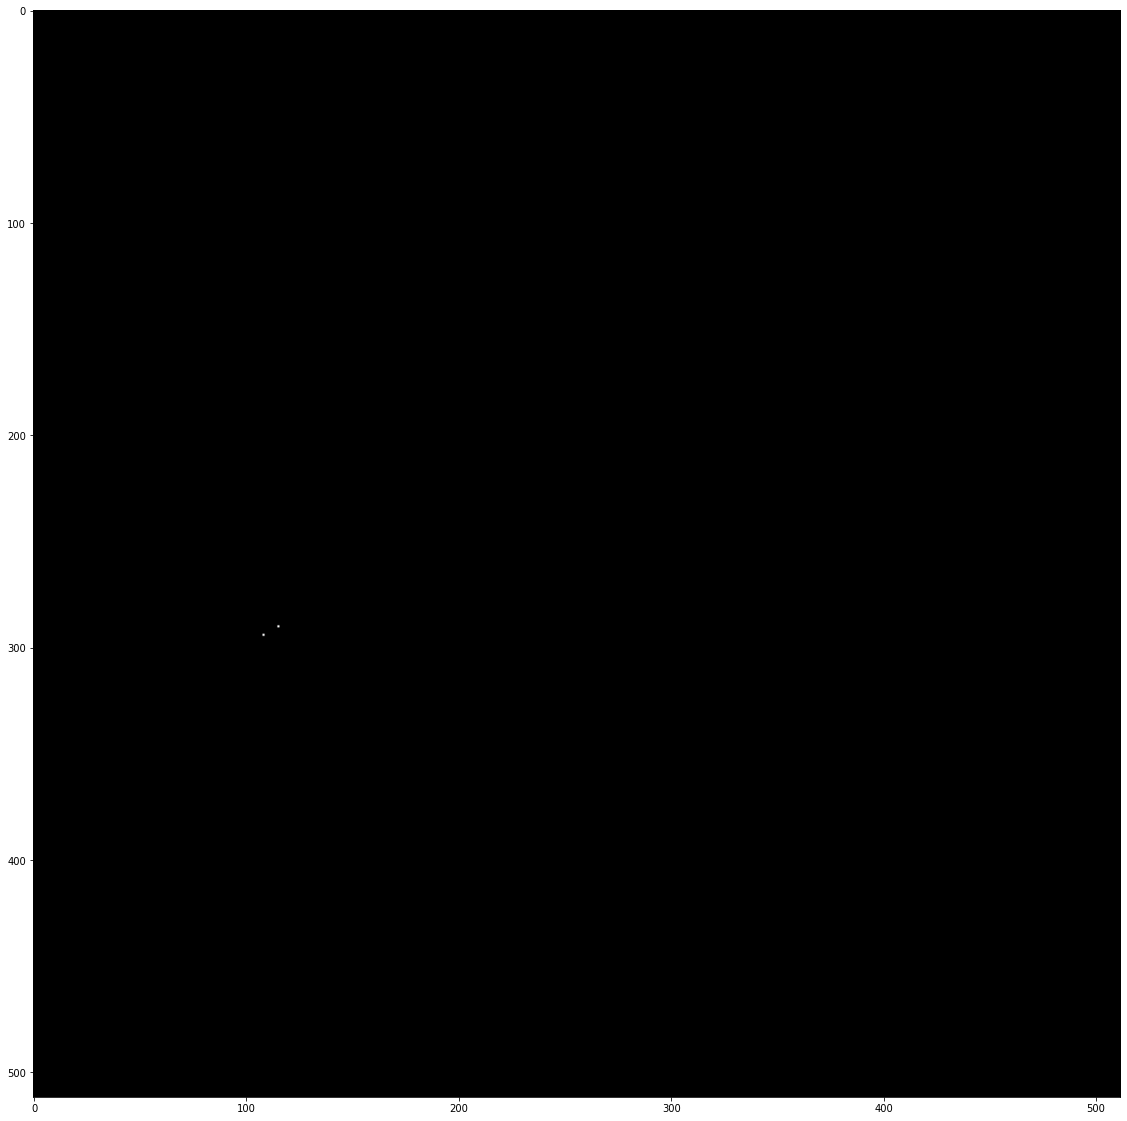

In [71]:
import math
x1 = int(cc[0][1])
x2 = int(cc[1][1])
y1 = int(cc[0][0])
y2 = int(cc[1][0])
d = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
b = np.zeros((512,512))
b[int(cc[0][0]), int(cc[0][1])]=255
b[int(cc[1][0]), int(cc[1][1])]=255
plt.figure(figsize=(20,20))
plt.imshow(b, cmap='gray')
print(d)

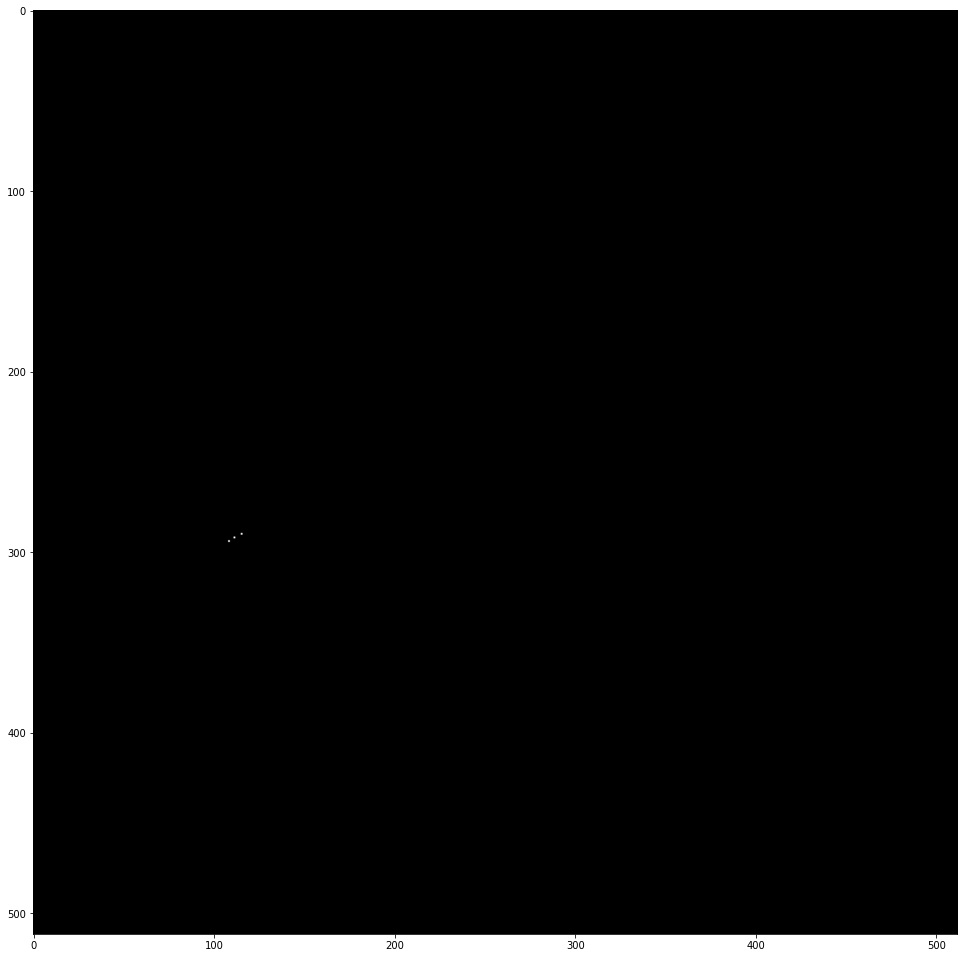

In [75]:
plt.figure(figsize=(17,17))
b[(y1+y2)//2, (x1+x2)//2] = 255
plt.imshow(b, cmap="gray")